<a href="https://colab.research.google.com/github/dDxCg/CMI-ML/blob/base/gridsearch_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Fitting 3 folds for each of 12 candidates, totalling 36 fits


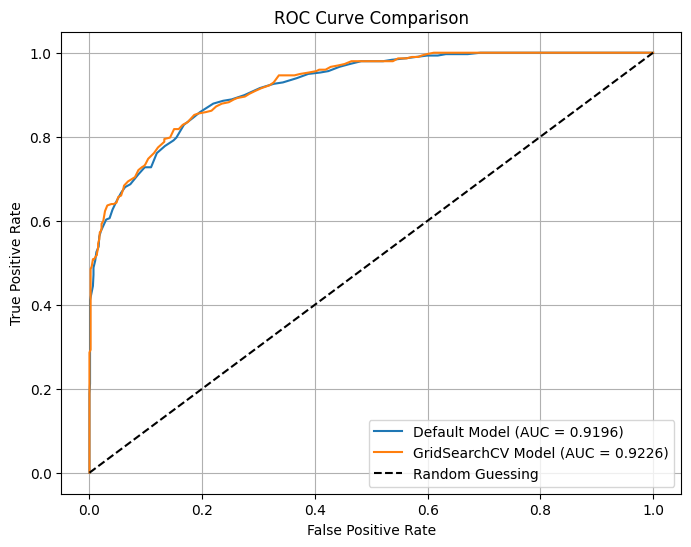

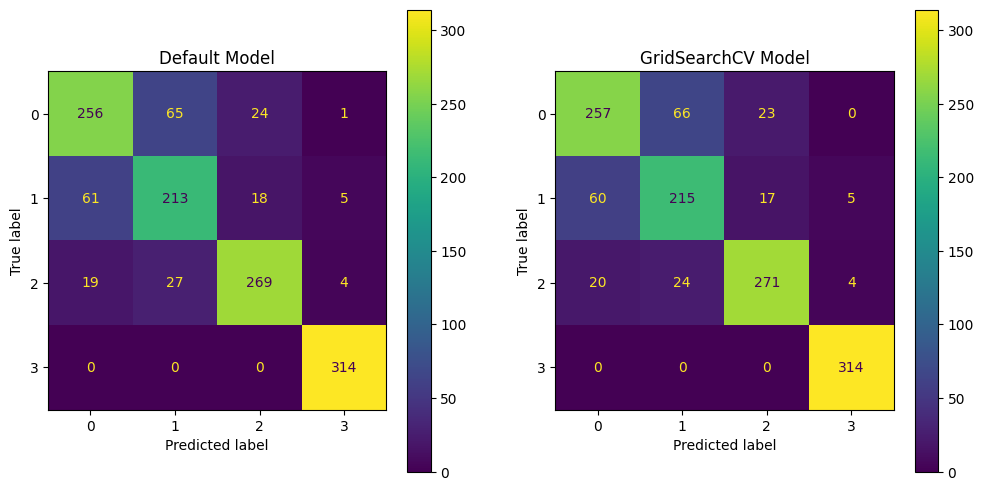

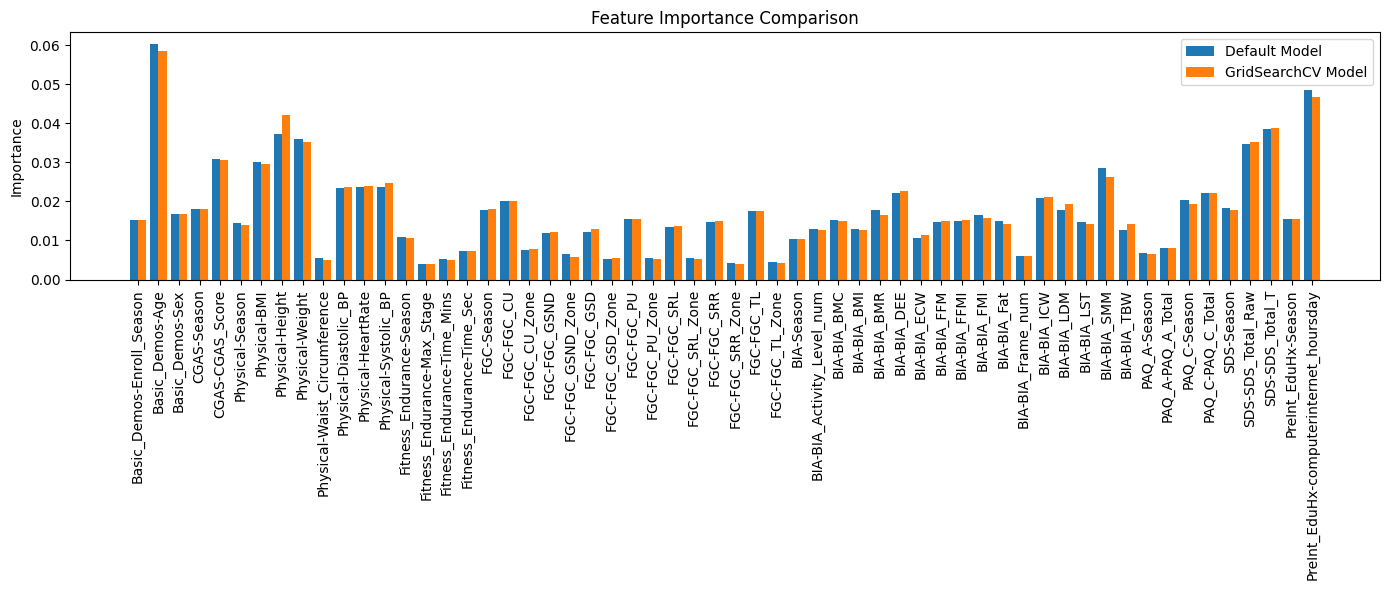

Metrics Comparison:
Default Model: {'Accuracy': 0.8244514106583072, 'Precision': 0.8238718013294395, 'Recall': 0.8244514106583072, 'F1-Score': 0.8239947835634212}
GridSearchCV Model: {'Accuracy': 0.8283699059561128, 'Precision': 0.8279357306492476, 'Recall': 0.8283699059561128, 'F1-Score': 0.8280048873641326}
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# Import thư viện cần thiết
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Đọc dữ liệu
train_file = '/content/drive/MyDrive/dataset/train.csv'
test_file = '/content/drive/MyDrive/dataset/test.csv'

df = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

# Xử lý cột ID
id_column = df_test['id']
df_test = df_test.drop(columns=['id'])
df = df.drop(columns=['id'])

# Xử lý cột mục tiêu
target = df.pop('sii')
df = df[target.notna()]
target = target[target.notna()]

# Mã hóa cột chuỗi
for column in df.columns:
    if df[column].dtype == object:
        df[column], _ = pd.factorize(df[column])
for column in df_test.columns:
    if df_test[column].dtype == object:
        df_test[column], _ = pd.factorize(df_test[column])

# Điền giá trị thiếu
df.fillna(df.median(), inplace=True)
df_test.fillna(df_test.median(), inplace=True)

# Đồng bộ hóa cột giữa df và df_test
common_columns = df.columns.intersection(df_test.columns)
df = df[common_columns]
df_test = df_test[common_columns]

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X = scaler.fit_transform(df)
X_test = scaler.transform(df_test)
y = target.values

# Cân bằng dữ liệu với SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X, y = smote.fit_resample(X, y)

# Chia dữ liệu huấn luyện và kiểm tra
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình mặc định
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Tìm kiếm tham số tốt nhất với GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc_ovr',  # AUC đa lớp
    cv=3,
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Lấy mô hình tốt nhất
best_model = grid_search.best_estimator_

# ROC Curve so sánh
y_val_proba_default = rf_model.predict_proba(X_val)
y_val_proba_grid = best_model.predict_proba(X_val)

fpr_default, tpr_default, _ = roc_curve(y_val, y_val_proba_default[:, 1], pos_label=1)
fpr_grid, tpr_grid, _ = roc_curve(y_val, y_val_proba_grid[:, 1], pos_label=1)

auc_default = auc(fpr_default, tpr_default)
auc_grid = auc(fpr_grid, tpr_grid)

plt.figure(figsize=(8, 6))
plt.plot(fpr_default, tpr_default, label=f"Default Model (AUC = {auc_default:.4f})")
plt.plot(fpr_grid, tpr_grid, label=f"GridSearchCV Model (AUC = {auc_grid:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Ma trận nhầm lẫn
y_val_pred_default = rf_model.predict(X_val)
y_val_pred_grid = best_model.predict(X_val)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred_default)).plot(ax=ax[0])
ax[0].set_title("Default Model")

ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred_grid)).plot(ax=ax[1])
ax[1].set_title("GridSearchCV Model")
plt.show()

# Feature Importance so sánh
feature_importance_default = rf_model.feature_importances_
feature_importance_grid = best_model.feature_importances_

x = np.arange(len(common_columns))
plt.figure(figsize=(14, 6))
plt.bar(x - 0.2, feature_importance_default, 0.4, label="Default Model")
plt.bar(x + 0.2, feature_importance_grid, 0.4, label="GridSearchCV Model")
plt.xticks(x, common_columns, rotation=90)
plt.title("Feature Importance Comparison")
plt.ylabel("Importance")
plt.legend()
plt.tight_layout()
plt.show()

# Bảng so sánh các chỉ số
metrics_default = {
    "Accuracy": accuracy_score(y_val, y_val_pred_default),
    "Precision": precision_score(y_val, y_val_pred_default, average="weighted"),
    "Recall": recall_score(y_val, y_val_pred_default, average="weighted"),
    "F1-Score": f1_score(y_val, y_val_pred_default, average="weighted"),
}

metrics_grid = {
    "Accuracy": accuracy_score(y_val, y_val_pred_grid),
    "Precision": precision_score(y_val, y_val_pred_grid, average="weighted"),
    "Recall": recall_score(y_val, y_val_pred_grid, average="weighted"),
    "F1-Score": f1_score(y_val, y_val_pred_grid, average="weighted"),
}

print("Metrics Comparison:")
print(f"Default Model: {metrics_default}")
print(f"GridSearchCV Model: {metrics_grid}")
print(f"Best Parameters: {grid_search.best_params_}")
